# Best practices for Green IT coding in python

In this tutorial, we will show good pratices for a green IT approach to code an image processing chain with efficiency in mind
Let's first define everything needed along this notebook

## Necessary imports for the notebook

In [4]:
import numpy as np
import rasterio
import xarray
import rioxarray as rxr
from numba import jit,njit
from xarray import DataArray 
from pathlib import Path
from typing import List, Tuple, Union, Dict
from dask import delayed
from dask.distributed import Client, LocalCluster, Lock
import dask.array as da
from rasterio.transform import Affine
import time
import os
import subprocess
from timeit import timeit

## Work directories for the notebook

In [3]:
input_dir = "/work/scratch/data/romaint/input_greenit"
output_dir = "/work/scratch/data/romaint/output_greenit"
perf_results_dir = "/work/scratch/env/romaint/greenit/perfos_greenit"
s2_b4 = f"{input_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B4.tif"
s2_b8 = f"{input_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B8.tif"
phr_product = "/work/scratch/data/tanguyy/public/PHR_OTB/Marmande/IMG_PHR1A_PMS_202304151100243_SEN_6967638101-1_R1C1_wnodata.tif"
phr_product_cog = f"{input_dir}/phr_cog.tif"
phr_product_lzw = f"{input_dir}/phr_lzw.tif"

# Good pratices for general python coding

## for loop optimisations : benefits of using numpy

using a for loop vs numpy for basic loop coding shows that you must avoid for loops in your code, here is a code snippet that shows the big performance difference to apply a square on 250 000 elements

In [19]:
start = time.perf_counter()
# Calculate square with for loop
array_forloop = []
for i in range(0,500):
    for j in range(0,500):
        array_forloop.append((i * j) ** 2)
    
end = time.perf_counter()
print("Time with for loop : {} ms".format((end-start)*1000))

# Using list comprehension instead of a for loop is a nice optimisation if your use case needs a for loop anyway
start = time.perf_counter()
array_forloop = [i**2 for i in range(0,250000)]
end = time.perf_counter()
print("Time with for list comprehension : {} ms".format((end-start)*1000))
      
# Using numpy
start = time.perf_counter()
arr = np.arange(250000)
squared_arr = np.square(arr)
end = time.perf_counter()
print("Time with numpy : {} ms".format((end-start)*1000))

Time with for loop : 83.00238009542227 ms
Time with for list comprehension : 63.063559122383595 ms
Time with numpy : 0.2981601282954216 ms


## Searching informations in your data

If your code needs to search elements in an image for example looking at NoData pixels, it is highly recommended to do that search in a set instead of a list of pixels :

In [29]:
nd_list = [i for i in range(0,100000)]
nd_set = set([i for i in range(0,100000)])
nd_array = np.arange(0,100000)

#Look at an element
def search_list():
    if 98950 in nd_list:
        pass
    
#Look at the same element in the set
def search_set():
    if 98950 in nd_set:
        pass

def search_numpy():
    if np.where(nd_array==98950):
        pass

#lets say nodata value is 98950 in that case
t1 = timeit(search_list, number=100000)
t2 = timeit(search_set, number=100000)
t3 = timeit(search_numpy, number=100000)
print("List search time: {} s".format(t1))
print("Set search time: {} s".format(t2))
print("Numpy search time: {} s".format(t3))

List search time: 42.939479635097086 s
Set search time: 0.006291795987635851 s
Numpy search time: 4.1151342540979385 s


## Conclusion

* Don't try to reinvent the wheel, use standard and well performing python libraries like numpy
* Avoid using for loops to apply a computing on a bunch of pixels, use numpy instead
* If you need a for loop for another processing, use list comprehension as much as possible, it is very well documented 
* Use sets when you need to lookup for values in your image but beware that the set is not intended to be modified. You can alternatively use numpy.where but it is not as efficient as the set because it returns a boolean array for each element of the array, nevertheless it is 10 times more efficient than a list.

For an in-depth comparison of how much numpy is faster than for and while loops, this link provides a complete performance comparison : https://www.blog.duomly.com/loops-in-python-comparison-and-performance/

# Profiling your processing chain with TREX monitoring

In order to optimize your chain, you have to check where are the bottlenecks of your program. The TREX cluster provides all the tools you need for that, with the monitoring module.

In this tutorial, we use this script to execute as a slurm job, which creates the graphs for CPU, RAM, DISK in png format. [See the graph section](#Performance-graphs-dask-compute-vs-rio.to_raster-with-tiled-write)

The in depth documentation is available [here](https://hpc.pages.cnes.fr/wiki-hpc-sphinx/module-monitoring-2.html)

## Write the monitoring script

In [59]:
greenit_script_monitored = """#!/bin/bash
#
# Load monitoring module
module load monitoring/2.2
#
# Use of SLURM $TMPDIR  of the interactive job
WORKDIR=$TMPDIR
SLURM_SUBMIT_DIR={perfo_result_dir}
#
cd "$WORKDIR"
#
# Give model name
#
MODEL_NAME=test_perfo_greenit
#
# launch start_monitoring.sh to start monitoring of the job ( --name option mandatory)
#
start_monitoring.sh --name $MODEL_NAME --io local
#
# lauch program
#
source /work/scratch/env/romaint/greenit/env_greenit_py312/bin/activate
python3 /work/scratch/env/romaint/greenit/test_parallelisation.py
#
# Stop monitoring -it will generate output_monitoring directory
#
stop_monitoring.sh --name $MODEL_NAME

"""

In [61]:
with open(f"{input_dir}/greenit_monitored.sh", 'w') as f:
    f.write(greenit_script_monitored.format(perfo_result_dir=perf_results_dir))
os.chmod(f"{input_dir}/greenit_monitored.sh", 0o755)

## Write the slurm script and submit the job

In [55]:
greenIT_slurm_script = """#!/bin/bash
#SBATCH --job-name=GreenIT_{cpus}_{mem}
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -c {cpus}
#SBATCH --mem={mem}G            # memory per node
#SBATCH --time=00:30:00             # Wall Time
#SBATCH --account=cnes_level2       # MANDATORY : account  ( launch myaccounts to list your accounts)
#SBATCH --export=none               # To start the job with a clean environnement and source of ~/.bashrc
#SBATCH --output={output_greenit}/greenIT-{cpus}-{mem}-%j.out
#SBATCH --error={output_greenit}/greenIT-{cpus}-{mem}-%j.err

sh {input_dir}/greenit_monitored.sh
"""

In [57]:
with open(f"{input_dir}/GreenIT.slurm", 'w') as f:
    f.write(greenIT_slurm_script.format(cpus=8,mem=56,input_dir=f"{input_dir}",output_greenit=f"{output_dir}"))
    f.flush()
output = subprocess.run(['sbatch', f"{input_dir}/GreenIT.slurm"], text=True, shell=False)
print(f"Submitted job {output}")

Submitted batch job 32975088
Submitted job CompletedProcess(args=['sbatch', '/work/scratch/data/romaint/input_greenit/GreenIT.slurm'], returncode=0)


## View the generated graphs

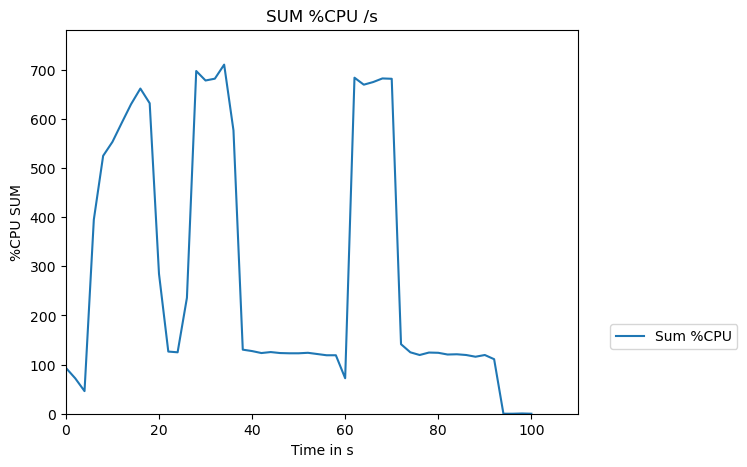

In [65]:
from IPython.display import Image
Image(filename=f"{perf_results_dir}/output_monitoring/CPU_SUM_-percent-CPU_-on-s.png")

# Choose a data format library adapted to your processing chain

Depending on your project, the data format will vary : you will need to choose a library that can fully handle your product.
A Tutorial is available [here](https://github.com/CNES/pluto-tuto/pull/3) for a detailed walkthrough on how to choose the right library

# A Green IT approach for coding image processing chains

In this notebook we will look at a green IT approach of coding, via good pratices in Python. We will have a look at Dask, RioXarray, rasterio, numpy... all these libraries that are widely used in the satellite image processing chains. 

## Defining usefull functions for our notebook

In [4]:
def open_raster_and_get_metadata(raster_paths: List[str], chunks: Union[int, Tuple, Dict, None], lock: Union[int,None]):
    """
    Opens multiple raster files, extracts shared geospatial metadata, 
    and returns the concatenated data along with resolution and CRS info.

    Parameters:
    -----------
    raster_paths : List[str]
        Paths to the raster files.
    chunks : Union[int, Tuple, Dict, bool, None]
        Chunk sizes for Dask (bands, height, width).

    Returns:
    --------
    Tuple[dask.array.Array, float, float, float, float, Union[str, CRS]]
        Concatenated raster data, x and y resolution, top-left coordinates, and CRS.
    """
    results = []
    for raster_path in raster_paths:
        with rxr.open_rasterio(raster_path, chunks=chunks, lock=lock) as tif:
            reprojection = tif
            transform = reprojection.rio.transform()
            crs = reprojection.rio.crs
            x_res = transform[0]
            y_res = -transform[4]
            top_left_x = transform[2]
            top_left_y = transform[5]
            results.append(reprojection)

    return da.concatenate(results), x_res, y_res, top_left_x, top_left_y, crs

def create_raster(data: np.ndarray, output_file: Path, x_res, y_res, top_left_x, top_left_y, crs):
    transform = Affine.translation(top_left_x, top_left_y) * Affine.scale(x_res, -y_res)
    with rasterio.open(
            output_file, "w",
            driver="GTiff",
            height=data.shape[1],
            width=data.shape[2],
            count=data.shape[0],
            dtype=data.dtype,
            crs=crs,
            transform=transform
    ) as dst:
        dst.write(data)

## Creating the Dask Cluster

In order to use dask we first need to create a [LocalCluster](https://docs.dask.org/en/stable/deploying-python.html#localcluster) which allow us to create workers and use [dask's dashboard](https://docs.dask.org/en/latest/dashboard.html).


In [3]:
cluster = LocalCluster()
client = Client(cluster)

print("Dask Dashboard: ", client.dashboard_link)
client

Dask Dashboard:  http://127.0.0.1:8787/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 56.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43565,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 56.00 GiB
Comm: tcp://127.0.0.1:32797,Total threads: 2
Dashboard: http://127.0.0.1:39065/status,Memory: 14.00 GiB
Nanny: tcp://127.0.0.1:45629,


Dask return an url where the dashboard is availaible (usually http://127.0.0.1:8787/status). This is not a tutorial on how to use this dashboard, but we recommend using it in a separate window while using this notebook.

# Use Case : Calculation of the Average NDVI on a Sentinel 2 image

In this example, we will use standard python libraries to: 

1. Read the data from the disk and stack them.
2. Calculate the associated NDVI, which combines multi-band information into a single band.
4. Write the resulting image to the disk.

First, let's read the data we need to perform the NDVI with RIOXarray.

### Open raster thanks to rioxarray

Here we are going to open the raster data required for this tutorial, the RGB bands from a Sentinel-2 acquisition. To do this, we're going to use rioxarray and, more specifically, the [open_rasterio](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio) method, which opens the images lazily (without loading data into memory) and returns a `dask.array` object. 
From this method we will use the ``chunks`` and ``lock`` arguments, which respectively set a chunk size and limit access to the data to one thread at a time to avoid read problems. Here ``chunks`` is set to ``True`` to allow dask to automatically size chunks.

When the data is read, we can express the NDVI calculation as if it were a numpy array. We add ``[None, :, :]`` to keep the shape as ``(bands, rows, cols)``. Then we can apply reduction on the dask.array and use ``compute()`` on it to triger the computation.

In [5]:
# Open the raster
reading_chunks = True
input_data_array, x_res, y_res, top_left_x, top_left_y, crs = open_raster_and_get_metadata([s2_b4,s2_b8], reading_chunks, False)
input_data_array

dask.array<concatenate, shape=(2, 10980, 10980), dtype=int16, chunksize=(1, 6111, 10980), chunktype=numpy.ndarray>

In [6]:
%%time

ndvi_array = (input_data_array[1] - input_data_array[0]) / (input_data_array[1] + input_data_array[0])[None, :, :]
# Launch the computing with dask with the compute call
mean_ndvi = ndvi_array.compute() 
crs="EPSG:4326"
output_file = Path(f"{output_dir}/ndvi_dask.tif")
create_raster(mean_ndvi, output_file, x_res , y_res,
                  top_left_x, top_left_y, crs)

CPU times: user 345 ms, sys: 1.49 s, total: 1.84 s
Wall time: 3.26 s


## Calculate NDVI With OTB in python

In [7]:
import otbApplication as otb

out_ndvi_otb_py=f"{output_dir}/img_ndvi_otb_py.tif"
#Compute NDVI with OTB in python
app_ndvi_otb = otb.Registry.CreateApplication("BandMath")
app_ndvi_otb.SetParameterStringList("il",[s2_b4,s2_b8])
app_ndvi_otb.SetParameterString("exp","(im2b1-im1b1)/(im2b1+im1b1)")
# Uncomment to compute NDVI for PLEIADES
#app_ndvi_otb.SetParameterStringList("il",[phr_product_cog])
#app_ndvi_otb.SetParameterString("exp","(im1b4-im1b1)/(im1b4+im1b1)")
app_ndvi_otb.SetParameterString("out",out_ndvi_otb_py)
app_ndvi_otb.SetParameterInt("ram",2048)
app_ndvi_otb.ExecuteAndWriteOutput()

Warning 1: Invalid value for NUM_THREADS: 


Writing /work/scratch/data/romaint/output_greenit/img_ndvi_otb_py.tif...: 100% [**************************************************] (2s)


0

## Calculate NDVI with OTB in C++
This part will call BandMath with the otb CLI to compare performances with the python swig interface

In [8]:
%%bash

WORK_DIR="/work/scratch/data/romaint"
otbcli_BandMath -il "${WORK_DIR}/input_greenit/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B4.tif" "${WORK_DIR}/input_greenit/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B8.tif" -exp "( im2b1 - im1b1 ) / ( im2b1 + im1b1 )" -out "${WORK_DIR}/output_greenit/img_ndvi_otb_cpp.tif" 

Warning 1: Invalid value for NUM_THREADS: 


Writing /work/scratch/data/romaint/output_greenit/img_ndvi_otb_cpp.tif...: 100% [**************************************************] (3s)


## Conclusion

The compute time with OTB for a simple NDVI computing is lower than standard python computing, this is mainly due to the overkill usage of dask with single band files.
Now let's see how to optimize our initial code, to determine when it using dask becomes important

# Compute time optimisation methods for NDVI

Let's see if we can improve the computing time with well known python libraries, with a Sentinel 2 product (size of about 2 Go if you include the bands you need only), every file is single band

In [9]:
%%time

#Define functions for each scenario
@njit
def one_pixel_ndvi(p1,p2):
    return (p2-p1) / (p2+p1) 

@njit
def compute_ndvi_numba(input_data_1: np.ndarray,input_data_2: np.ndarray):
    #ndvi_array = [one_pixel_ndvi(i,j) for i in input_data_1 for j in input_data_2]
    ndvi_array = (input_data_2 - input_data_1) / (input_data_2 + input_data_1)
    return ndvi_array

def compute_ndvi_dask(input_data_1: DataArray,input_data_2: DataArray):
    ndvi_array = ((input_data_2 - input_data_1) / (input_data_2 + input_data_1))[None,:,:]
    ndvi_array.compute()
    return ndvi_array

def compute_ndvi_std(input_data_1: np.ndarray,input_data_2: np.ndarray):
    #ndvi_array = [one_pixel_ndvi(i,j) for i in input_data_1 for j in input_data_2]
    ndvi_array = (input_data_2 - input_data_1) / (input_data_2 + input_data_1)
    return ndvi_array
#Compute with numba
start = time.perf_counter()
with rasterio.open(s2_b4, 'r') as ds:
    input_data_b4 = ds.read() 

with rasterio.open(s2_b8, 'r') as ds:
    input_data_b8 = ds.read()

ndvi_computed = compute_ndvi_numba(input_data_b4,input_data_b8)
crs="EPSG:4326"
output_file = Path(f"{output_dir}/ndvi_numba.tif")
create_raster(ndvi_computed, output_file, x_res , y_res, top_left_x, top_left_y, crs)
end = time.perf_counter()
print("Time to compute with Raster IO + numba = {}s".format((end - start)))

start = time.perf_counter()
with rasterio.open(s2_b4, 'r') as ds:
    input_data_b4 = ds.read() 

with rasterio.open(s2_b8, 'r') as ds:
    input_data_b8 = ds.read()

ndvi_computed = compute_ndvi_std(input_data_b4,input_data_b8)
crs="EPSG:4326"
output_file = Path(f"{output_dir}/ndvi_without_numba.tif")
create_raster(ndvi_computed, output_file, x_res , y_res,top_left_x, top_left_y, crs)
end = time.perf_counter()
print("Time to compute with Raster IO + without numba = {}s".format((end - start)))
# Example with xarray
start = time.perf_counter()
input_data_b4 =  xarray.open_dataarray(s2_b4)
input_data_b8 =  xarray.open_dataarray(s2_b8)
ndvi_computed = xarray.apply_ufunc(compute_ndvi_std,input_data_b4,input_data_b8)
output_file = Path(f"{output_dir}/ndvi_ufunc.tif")
ndvi_computed.rio.to_raster(output_file)
end = time.perf_counter()
print("Time to compute with Xarray + apply ufunc = {}s".format((end - start)))

start = time.perf_counter()
input_data, x_res, y_res, top_left_x, top_left_y, crs = open_raster_and_get_metadata([s2_b4,s2_b8], (-1,2200,2200), False)
ndvi_array = compute_ndvi_dask(input_data[0],input_data[1])
output_file = Path(f"{output_dir}/ndvi_dask.tif")
create_raster(ndvi_array, output_file, x_res , y_res, top_left_x, top_left_y, crs)
end = time.perf_counter()
print("Time to compute with RIOXarray + dask = {}s".format((end - start)))


Time to compute with Raster IO + numba = 2.2769373627379537s
Time to compute with Raster IO + without numba = 1.8911610832437873s
Time to compute with Xarray + apply ufunc = 3.2426639813929796s
Time to compute with RIOXarray + dask = 5.112378729507327s
CPU times: user 2.59 s, sys: 5.61 s, total: 8.2 s
Wall time: 12.5 s


## Conclusion for a Sentinel 2 product with single band files (~3Go for the full product)

* Using **RIOXarray + dask on single band product is counter productive**.
* Xarray + applyufunc also leads to low performance compared to opening the whole product with rasterio.
* Using numba do enhances the performance but after the first compilation, if you start it once it will take more time that the computing without numba. It is more suitable for numpy vectorize [optimisation]( https://numba.readthedocs.io/en/stable/user/vectorize.html#the-vectorize-decorator)


# The importance of reducing the size of your data

Let's see how the size of your data can have an impact on your compute time

In [20]:
## Read the initial raster

raster = rasterio.open(phr_product, 'r')
raster.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 39844, 'height': 41663, 'count': 4, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockxsize': 39844, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}

## Simple LZW Compression with RasterIO

In [21]:
%%time

# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = raster.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(compress='lzw')

    with rasterio.open(phr_product_lzw, 'w', **profile) as dst:
        dst.write(raster.read(1), 1)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


CPU times: user 1min 13s, sys: 5.12 s, total: 1min 19s
Wall time: 1min 17s


## Create a CoG without overview

In [22]:
%%time

with rasterio.Env():
    profile = raster.profile
    profile.update(tiled=True, compress='lzw', blockxsize=512, blockysize=512)
    with rasterio.open(phr_product_cog, 'w', **profile) as dst:
        dst.write(raster.read(1), 1)

CPU times: user 1min 11s, sys: 5.54 s, total: 1min 17s
Wall time: 1min 22s


## Create Cog with overview

A library exists to manipulate CoG with overviews: https://github.com/cogeotiff/rio-cogeo/

## Size and compute time gain after compression

In [5]:
!du -sh {input_dir}/*

512	/work/scratch/data/romaint/input_greenit/GreenIT.slurm
1.5G	/work/scratch/data/romaint/input_greenit/SENTINEL2A_20210415-105852-555_L2A_T31TCJ_C_V3-0_FRE_STACK.tif
2.8G	/work/scratch/data/romaint/input_greenit/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1
2.0G	/work/scratch/data/romaint/input_greenit/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1.tar.gz
512	/work/scratch/data/romaint/input_greenit/greenit_monitored.sh
299M	/work/scratch/data/romaint/input_greenit/image_PHR_marmande.zip
1.6G	/work/scratch/data/romaint/input_greenit/phr_cog.tif
35M	/work/scratch/data/romaint/input_greenit/phr_cog_extract.tif
1.7G	/work/scratch/data/romaint/input_greenit/phr_lzw.tif


### Compute time with RIOXarray and compressed files

In [16]:
reading_chunks = (-1,2048,2048)
start=time.perf_counter()
data_array_lzw = rxr.open_rasterio(phr_product_lzw, chunks=reading_chunks, lock=False)
ndvi_array = (data_array_lzw[3] - data_array_lzw[0]) / (data_array_lzw[3] + data_array_lzw[0])
output_file = Path(f"{output_dir}/ndvi_lzw.tif")
ndvi_array.rio.to_raster(output_file)
end=time.perf_counter()
print("Time to compute with LZW compressed file = {}s".format((end - start)))

start=time.perf_counter()
data_array_cog = rxr.open_rasterio(phr_product_cog, chunks=reading_chunks, lock=False)
ndvi_array = (data_array_cog[3] - data_array_cog[0]) / (data_array_cog[3] + data_array_cog[0])
output_file = Path(f"{output_dir}/ndvi_cog.tif")
ndvi_array.rio.to_raster(output_file)
end=time.perf_counter()
print("Time to compute with CoG compressed file = {}s".format((end - start)))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Time to compute with LZW compressed file = 148.64071926195174s


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Time to compute with CoG compressed file = 50.54504857957363s


## Conclusion

* Using LZW or CoG does reduce the size of your data on disk and reduce the computing time, but **beware than in memory the product size will still be the original product's size**

<div style="border: 2px solid red; padding: 10px; background-color: #ffe6e6; color: red;">
    
* Using CoG is **way more efficient in computational time, you can gain up to 200%** with a simple NDVI indice computing. See the next chapter on how to optimize the disk write to gain more time.
    
</div>


## The size of your image should lead you to use the right library

<div style="border: 2px solid red; padding: 10px; background-color: #ffe6e6; color: red;">
If your product is single band or its size is less than your RAM size divided by the number of CPUs (not threads), it is not recommended to use parallelisation libraries such as dask
</div>

Let's say you have an average computer that has 16 or 32Go RAM : with this amount of ram we recommend using dask if your **product size is > 3 Go**

<div style="border: 2px solid red; padding: 10px; background-color: #ffe6e6; color: red;">
If your product is multi-band, use RIOXarray and/or Dask, we will see in the next chapter that you can tune the parameters to improve the read/write performances
</div>


Let's see a use case where parralellisation methods are worth it

# Use case : I have to use multiple products which average size is > 10Go

In this example we will use a PLEIADES product (which original size is 13Go) in CoG format which size is 1.6 Go

This is the typical use case where dask or rioxarray with parallel read and write support is necessary to speedup your processing. Let's see what are the recommended parameters to optimize your processing with big data

## Using dask and optimizing its parameters

### Find the right chunk size for dask

Chunk size is becoming very important when your data size grows. You can let chunks=True to dask which will automatically determine a chunk size
Most of the time this chunk size is coherent but users can tweak it to be more efficient.

Also be careful about the compute() method, which is not recommended when your data size => 10Go, the memory consumption increases a lot

In [10]:
# First example letting dask compute the chunks
reading_chunks = True
data_array_autochunks = rxr.open_rasterio(phr_product_cog, chunks=reading_chunks,lock=False)
data_array_autochunks

<xarray.DataArray (band: 4, y: 41663, x: 39844)> Size: 13GB
dask.array<open_rasterio-80e78a4b45c26ac423b4a17c1494e93e<this-array>, shape=(4, 41663, 39844), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 319kB 0.5 1.5 2.5 ... 3.984e+04 3.984e+04 3.984e+04
  * y            (y) float64 333kB 0.5 1.5 2.5 ... 4.166e+04 4.166e+04 4.166e+04
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0

In [16]:
start=time.perf_counter()
ndvi_array = (data_array_autochunks[3] - data_array_autochunks[0]) / (data_array_autochunks[3] + data_array_autochunks[0])
output_file = Path(f"{output_dir}/ndvi_autochunks.tif")
ndvi_array.rio.to_raster(output_file,tiled=True)
end=time.perf_counter()
print("Time to compute with automatic chunk size = {}s".format((end - start)))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Time to compute with automatic chunk size = 49.639332056976855s


In [21]:
reading_chunks = (-1,2048,2048)
data_array_manualchunks = rxr.open_rasterio(phr_product_cog, chunks=reading_chunks, lock=False)
data_array_manualchunks

<xarray.DataArray (band: 4, y: 41663, x: 39844)> Size: 13GB
dask.array<open_rasterio-378202cf7021cd8ef82947b521bf5afc<this-array>, shape=(4, 41663, 39844), dtype=uint16, chunksize=(4, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 319kB 0.5 1.5 2.5 ... 3.984e+04 3.984e+04 3.984e+04
  * y            (y) float64 333kB 0.5 1.5 2.5 ... 4.166e+04 4.166e+04 4.166e+04
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0

In [22]:
start=time.perf_counter()
ndvi_array = (data_array_manualchunks[3] - data_array_manualchunks[0]) / (data_array_manualchunks[3] + data_array_manualchunks[0])
output_file = Path(f"{output_dir}/ndvi_manualchunks.tif")
ndvi_array.rio.to_raster(output_file,tiled=True)
end=time.perf_counter()
print("Time to compute with manual chunk size = {}s".format((end - start)))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Time to compute with manual chunk size = 43.15807781834155s


### Conclusion

With this example we demonstrated that using personalized chunk size can give you immediatly a 10% performance improvment, we highly encourage using chunks in coherence with your CoG size, using multi-band chunks.

<div style="border: 2px solid red; padding: 10px; background-color: #ffe6e6; color: red;">
Prefer using rxr.to_raster() instead of dask.compute() when your product size is getting bigger as the later seems to be more CPU consuming
</div>

#### Chunk size recommandation for multi band products

When using multiple band products, dask will automaticaly take chunks per band, which slows done the processing

<div style="border: 2px solid red; padding: 10px; background-color: #ffe6e6; color: red;">
We recommand in that case defining chunks using "(-1,sizex,sizey)" which creates chunks with concatenated bands. The time gain can be up to 20% !
</div>

#### Don't hesitate to test different chunk sizes before making a conclusion

In our case we used chunks of 32Mo, it is a best practice to use chunks size multiple of the tile size for read/write efficiency in RAM.
Tests have been done with chunks > 128Mo, bigger chunks tends to slow down the process.

<div style="border: 2px solid red; padding: 10px; background-color: #ffe6e6; color: red;">
Don't use chunks > 256Mo as it becomes counter-productive
</div>

#### Adjust the number of workers for dask

If you have a lot of CPU, you can also gain time by adjusting the number of workers for dask, here for 8 CPU we used 4 workers, which gives 2 threads per CPU which is the perfect scenario for modern CPUs with hyperthreading (8 Core => 16 Threads)

## Improve disk write speed with rio.to_raster 

In the previous computing, we didn't use the tiled write capability of rio.to_raster, which speeds up the image writing on disk.
Let's see how to use it

In [25]:
%%time

start = time.perf_counter()
reading_chunks = (-1,2048,2048)
input_data_array = rxr.open_rasterio(phr_product_cog,chunks=reading_chunks,lock=False)
ndvi_phr = (input_data_array[3] - input_data_array[0]) / (input_data_array[3] + input_data_array[0])
ndvi_phr.compute()
output_file = Path(f"{output_dir}/ndvi_phr.tif")
ndvi_phr.rio.to_raster(output_file)
end = time.perf_counter()
print("Time to compute with RIOXarray + dask compute + product > 5Go = {}s".format((end - start)))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Time to compute with RIOXarray + dask compute + product > 5Go = 80.12519567552954s
CPU times: user 13.5 s, sys: 49.8 s, total: 1min 3s
Wall time: 1min 20s


In [11]:
input_data_array

<xarray.DataArray (band: 4, y: 41663, x: 39844)> Size: 13GB
dask.array<open_rasterio-378202cf7021cd8ef82947b521bf5afc<this-array>, shape=(4, 41663, 39844), dtype=uint16, chunksize=(4, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 319kB 0.5 1.5 2.5 ... 3.984e+04 3.984e+04 3.984e+04
  * y            (y) float64 333kB 0.5 1.5 2.5 ... 4.166e+04 4.166e+04 4.166e+04
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0

In [26]:
start = time.perf_counter()
reading_chunks = (-1,2048,2048)
input_data_array = rxr.open_rasterio(phr_product_cog,chunks=reading_chunks,lock=False)
ndvi_phr = (input_data_array[3] - input_data_array[0]) / (input_data_array[3] + input_data_array[0])
output_file = Path(f"{output_dir}/ndvi_phr_rxr.tif")
# Don't call dask.compute, use rio.to_raster to launch the dask computing on the background
# Add the Tiled=true parameter to rxr to speed up the disk write
ndvi_phr.rio.to_raster(output_file,tiled=True)
end = time.perf_counter()
print("Time to compute with RIOXarray + tiled write + product > 5Go = {}s".format((end - start)))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Time to compute with RIOXarray + tiled write + product > 5Go = 51.08986523933709s


## Performance graphs dask compute vs rio.to_raster with tiled write

This graph has been generated on TREX, with leads to better performance than in this notebook

**The first computing stops at 55s in these graphs that were generated using a slurm script with the exact same code as above**

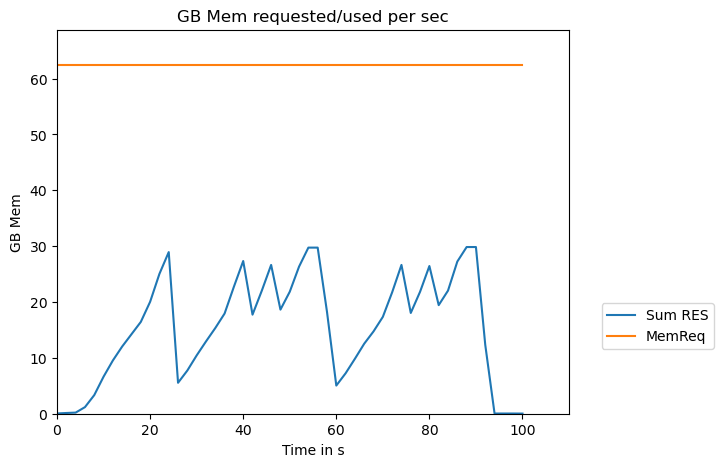

In this memory usage graph we can conclude that the memory usage for both methods is the same (due to rioxarray way to handle the memory)

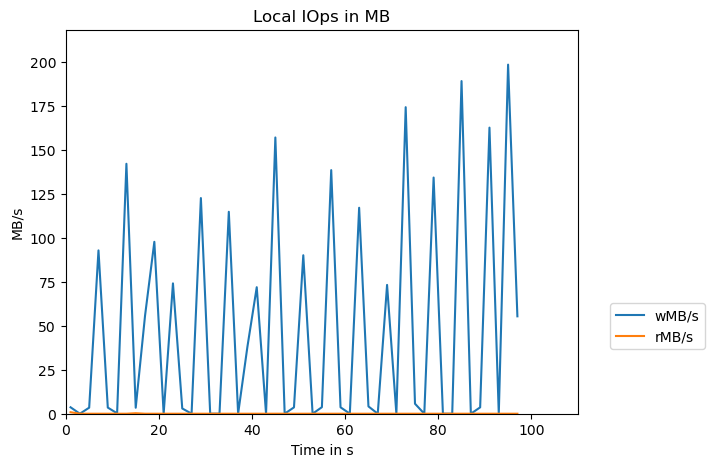

The local IO per second graph shows that the tiled write indeed produces a higher level of IOps to make the file write faster, but it is restricted by the speed of your SSD.

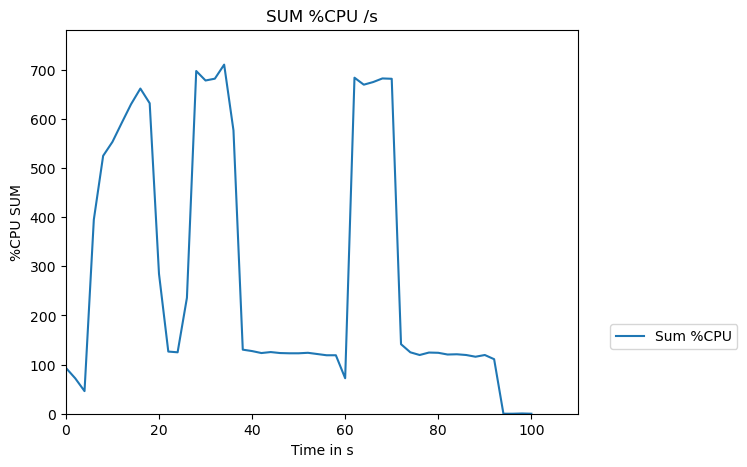

The CPU usage shows 2 peaks for the computing with dask, only 1 peak with the tiled write scenario

**Conclusion for the performance graphs**

* Both method consumes the same amount of memory ~ 2x the initial product size
* Cpu usage is **higher with dask.compute() method**

## Conclusions

The initial compute time for an NDVI on the pleiade tile was around 150s, with all the optimisations (CoG compression, parallelisation dask + rioxarray_to raster with tiled=true) we were able to go down to 35s, which **divided the compute time by 3!**

For an NDVI on the same product, the performance difference between these two parallelisation methods is 55s vs 35s here : **57%!**

### Recommandations

<div style="border: 2px solid red; padding: 10px; background-color: #ffe6e6; color: red;">
    
* Use **lock=False** and **chunks=(-1,sizex,sizey)** for reading the file to improve READ time
  
* Use **tiled=True** parameter to rio.to_raster to improve WRITE performance

</div>

* Use rio.to_raster to compute/write in parallel, instead of dask.compute and then write

* Using parallelisation methods dask / RIOXarray leads to a huge time gain without precision loss with big multiband products

* You have to carefully choose your chunk size using a multiple of the cog size


# Estimate the carbon impact of your code
Using code carbon you can have an estimate of your code footprint,
Here we would like to calculate the carbon footprint of an NDVI for a S2 and a PHR image for comparison

In [9]:
from codecarbon import track_emissions, EmissionsTracker

tracker = EmissionsTracker()

#@track_emissions()
def compute_ndvi_sentinel2():
    input_data_b4 =  xarray.open_dataarray(s2_b4)
    input_data_b8 =  xarray.open_dataarray(s2_b8)
    ndvi_computed = xarray.apply_ufunc(compute_ndvi_std,input_data_b4,input_data_b8)
    output_file = Path(f"{output_dir}/ndvi_ufunc_sentinel2.tif")
    ndvi_computed.rio.to_raster(output_file)

#@track_emissions()
def compute_ndvi_phr():
    input_data_phr = xarray.open_dataarray(phr_product_cog)
    ndvi_computed = xarray.apply_ufunc(compute_ndvi_std,input_data_phr[0],input_data_phr[3])
    output_file = Path(f"{output_dir}/ndvi_ufunc_phr.tif")
    ndvi_computed.rio.to_raster(output_file)

tracker.start()
start = time.perf_counter()
compute_ndvi_sentinel2()
end = time.perf_counter()
print("Time to compute to compute sentinel 2 NDVI = {}s".format((end - start)))

start = time.perf_counter()
compute_ndvi_phr()
end = time.perf_counter()
print("Time to compute to compute PHR Ventoux NDVI = {}s".format((end - start)))
tracker.stop()

ModuleNotFoundError: No module named 'codecarbon'